## Setup & Imports

In [15]:
# --- IMPORTS ---
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
)

# For reproducibility
RNG = 42
np.random.seed(RNG)


## Load data
> The target column is `Rings`.



In [16]:

# Load Data:
DATA_PATH = r"abalone.data.csv" 

# First row is header
abalone = pd.read_csv(DATA_PATH, sep=",", header=0)
df = pd.read_csv(DATA_PATH, sep=",", header=0)
assert "Rings" in df.columns, "Expected 'Rings' column."
print(df.shape)
print(df.dtypes)
df.head()


(4177, 9)
gender             object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


,gender,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Quick sanity 
> Checking to ensure there is no missing data

In [17]:

display(df.describe(include='all'))
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


,gender,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,NaN,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,NaN,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,NaN,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,NaN,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000



Missing values per column:
gender            0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


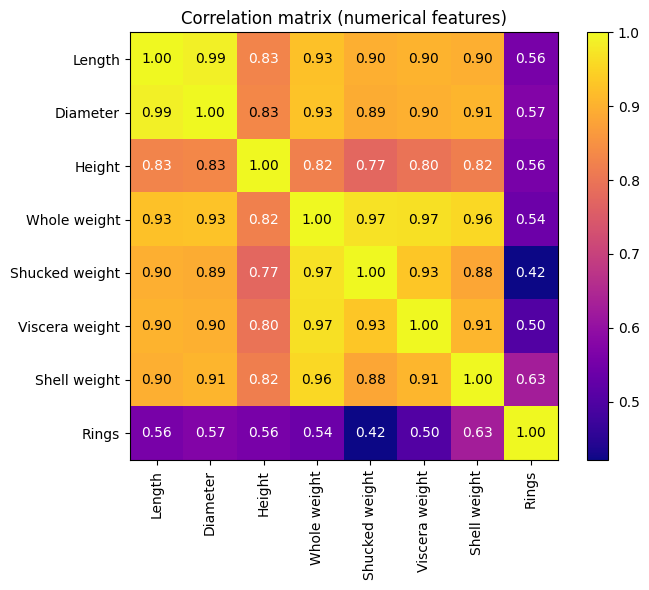

In [18]:
# Correlation matrix (numerical values only)
corr = abalone.corr(numeric_only=True)  
plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, cmap='plasma', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix (numerical features)")
plt.colorbar(im, fraction=0.046, pad=0.04)

threshold = corr.values.mean()
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        
        # Set text color based on cell's background brightness
        text_color = "black" if value > threshold else "white"
        
        plt.text(
            j, i,                       # (x, y) position
            f"{value:.2f}",             # The text to plot (formatted)
            ha="center", va="center",   # Center horizontally and vertically
            color=text_color            # Set the color
        )


plt.tight_layout()
plt.show()


## Clean data
The previous evaluation of the data shows that the minimum value in the height column was 0.
Since 0 height is not physically possible, these entries were removed.

In [19]:
# Check for zero height
zero_height_count = (df['Height'] == 0).sum()
if zero_height_count > 0:
    print(f"Found {zero_height_count} instances with Height = 0.")
    df = df[df['Height'] > 0].copy()   # Remove these rows
    print(f"Removed rows with Height = 0. New shape: {df.shape}")           

else:
    print("No instances with Height = 0 found.")


Found 2 instances with Height = 0.
Removed rows with Height = 0. New shape: (4175, 9)


In [20]:
numeric_cols = df.columns.drop("gender")
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce") # Convert values in all columns except gender to numeric, returns NaN is the entry is not a number

df = pd.get_dummies(df, columns=["gender"], drop_first=True) #one-hot encoding gender so it can be used in regression models
# Drop gender_F to avoid multicollinearity
# Keeping all 3 provides perfect linearity between the 3 columns so one column can be predicted from the other two.
# Dropping one avoids redundancy. If gender_M = 0 and gender_I = 0, the observation must be F (treated as the baseline).

print(df.info(), "\n")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 4175 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4175 non-null   float64
 1   Diameter        4175 non-null   float64
 2   Height          4175 non-null   float64
 3   Whole weight    4175 non-null   float64
 4   Shucked weight  4175 non-null   float64
 5   Viscera weight  4175 non-null   float64
 6   Shell weight    4175 non-null   float64
 7   Rings           4175 non-null   int64  
 8   gender_I        4175 non-null   bool   
 9   gender_M        4175 non-null   bool   
dtypes: bool(2), float64(7), int64(1)
memory usage: 301.7 KB
None 



,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,gender_I,gender_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,True,False


## Set up for regression models

In [21]:
# Define Data
X = df.drop(columns=["Rings"])
y_reg = df["Rings"]

# Split Data 80-20 train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=RNG
)

kf = KFold(n_splits=5, shuffle=True, random_state=RNG)

## Linear Regression


In [22]:
# Linear Model Pipeline
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Cross Validation
cv_lin = cross_validate(
    lin_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)

# Cross Validation Results
print("--- Linear Model CV Results ---")
print(f"CV Mean R2 (train):  {cv_lin['train_r2'].mean():.3f} ± {cv_lin['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_lin['test_r2'].mean():.3f}  ± {cv_lin['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_lin['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_lin['test_neg_mean_absolute_error'].mean():.3f}")

# Final Evaluation on Test Set
t0 = time.time()
lin_pipe.fit(X_train_r, y_train_r)
lin_train_time = time.time() - t0 

# Prediction
t1 = time.time()
y_pred_lin = lin_pipe.predict(X_test_r) 
lin_pred_time = time.time() - t1  

# Final Metrics
rmse_lin = np.sqrt(mean_squared_error(y_test_r, y_pred_lin)) 
mae_lin = mean_absolute_error(y_test_r, y_pred_lin)      
r2_lin = r2_score(y_test_r, y_pred_lin)                  

print("\n--- Linear Model Test Results ---")
print(f"Test RMSE: {rmse_lin:.3f} | Test MAE: {mae_lin:.3f} | Test R2: {r2_lin:.3f}")
print(f"Train time: {lin_train_time*1000:.1f} ms | Predict time: {lin_pred_time*1000:.1f} ms")


--- Linear Model CV Results ---
CV Mean R2 (train):  0.530 ± 0.003
CV Mean R2 (val):    0.510  ± 0.024
CV Mean RMSE (val):  2.227
CV Mean MAE (val):   1.587

--- Linear Model Test Results ---
Test RMSE: 2.216 | Test MAE: 1.591 | Test R2: 0.570
Train time: 4.8 ms | Predict time: 1.3 ms


## Ridge Regression

In [23]:
# Ridge Model Pipeline
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RNG))
])

# Cross Validation
cv_ridge = cross_validate(
    ridge_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)

# Cross Validation Results
print("\n--- Ridge Model CV Results ---")
print(f"CV Mean R2 (train):  {cv_ridge['train_r2'].mean():.3f} ± {cv_ridge['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_ridge['test_r2'].mean():.3f}  ± {cv_ridge['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_ridge['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_ridge['test_neg_mean_absolute_error'].mean():.3f}")

# Final Evaluation on Test Set
t0 = time.time()
ridge_pipe.fit(X_train_r, y_train_r)
ridge_train_time = time.time() - t0 

# Prediction
t1 = time.time()
y_pred_ridge = ridge_pipe.predict(X_test_r) 
ridge_pred_time = time.time() - t1    

# Final Metrics
rmse_ridge = np.sqrt(mean_squared_error(y_test_r, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test_r, y_pred_ridge)
r2_ridge = r2_score(y_test_r, y_pred_ridge)    

print("\n--- Ridge Model Test Results ---")
print(f"Test RMSE: {rmse_ridge:.3f} | Test MAE: {mae_ridge:.3f} | Test R2: {r2_ridge:.3f}")
print(f"Train time: {ridge_train_time*1000:.1f} ms | Predict time: {ridge_pred_time*1000:.1f} ms")



--- Ridge Model CV Results ---
CV Mean R2 (train):  0.530 ± 0.003
CV Mean R2 (val):    0.510  ± 0.024
CV Mean RMSE (val):  2.226
CV Mean MAE (val):   1.587

--- Ridge Model Test Results ---
Test RMSE: 2.218 | Test MAE: 1.592 | Test R2: 0.569
Train time: 3.9 ms | Predict time: 1.2 ms


## Comparison of results from each regression model

In [24]:
# Combining data into a comparison table
comparison_data = {
    # Test Set Scores (Final Performance)
    "Test R2": [r2_lin, r2_ridge],
    "Test RMSE": [rmse_lin, rmse_ridge],
    "Test MAE": [mae_lin, mae_ridge],
    
    # CV Validation Scores (Generalization)
    "CV Val R2 (avg)": [cv_lin['test_r2'].mean(), cv_ridge['test_r2'].mean()],
    "CV Val RMSE (avg)": [
        np.mean(np.sqrt(-cv_lin['test_neg_mean_squared_error'])), 
        np.mean(np.sqrt(-cv_ridge['test_neg_mean_squared_error']))
    ],
    
    # CV Training Scores (To check for overfitting)
    "CV Train R2 (avg)": [cv_lin['train_r2'].mean(), cv_ridge['train_r2'].mean()],
    
    # Computational Efficiency
    "Train Time (ms)": [lin_train_time * 1000, ridge_train_time * 1000],
    "Predict Time (ms)": [lin_pred_time * 1000, ridge_pred_time * 1000]
}


index_labels = ["Linear", "Ridge"]
comparison_df = pd.DataFrame(comparison_data, index=index_labels)

# Calculate Overfitting Metric
comparison_df["Overfit (Train R2 - Val R2)"] = \
    comparison_df["CV Train R2 (avg)"] - comparison_df["CV Val R2 (avg)"]


styled_df = comparison_df.style.format({
    "Test R2": "{:.4f}",
    "Test RMSE": "{:.4f}",
    "Test MAE": "{:.4f}",
    "CV Val R2 (avg)": "{:.4f}",
    "CV Val RMSE (avg)": "{:.4f}",
    "CV Train R2 (avg)": "{:.4f}",
    "Overfit (Train R2 - Val R2)": "{:.4f}",
    "Train Time (ms)": "{:.1f} ms",
    "Predict Time (ms)": "{:.1f} ms"
})

display(styled_df)

,Test R2,Test RMSE,Test MAE,CV Val R2 (avg),CV Val RMSE (avg),CV Train R2 (avg),Train Time (ms),Predict Time (ms),Overfit (Train R2 - Val R2)
Linear,0.5696,2.2162,1.5906,0.5099,2.2270,0.5297,4.8 ms,1.3 ms,0.0198
Ridge,0.5689,2.2180,1.5918,0.5102,2.2264,0.5296,3.9 ms,1.2 ms,0.0194


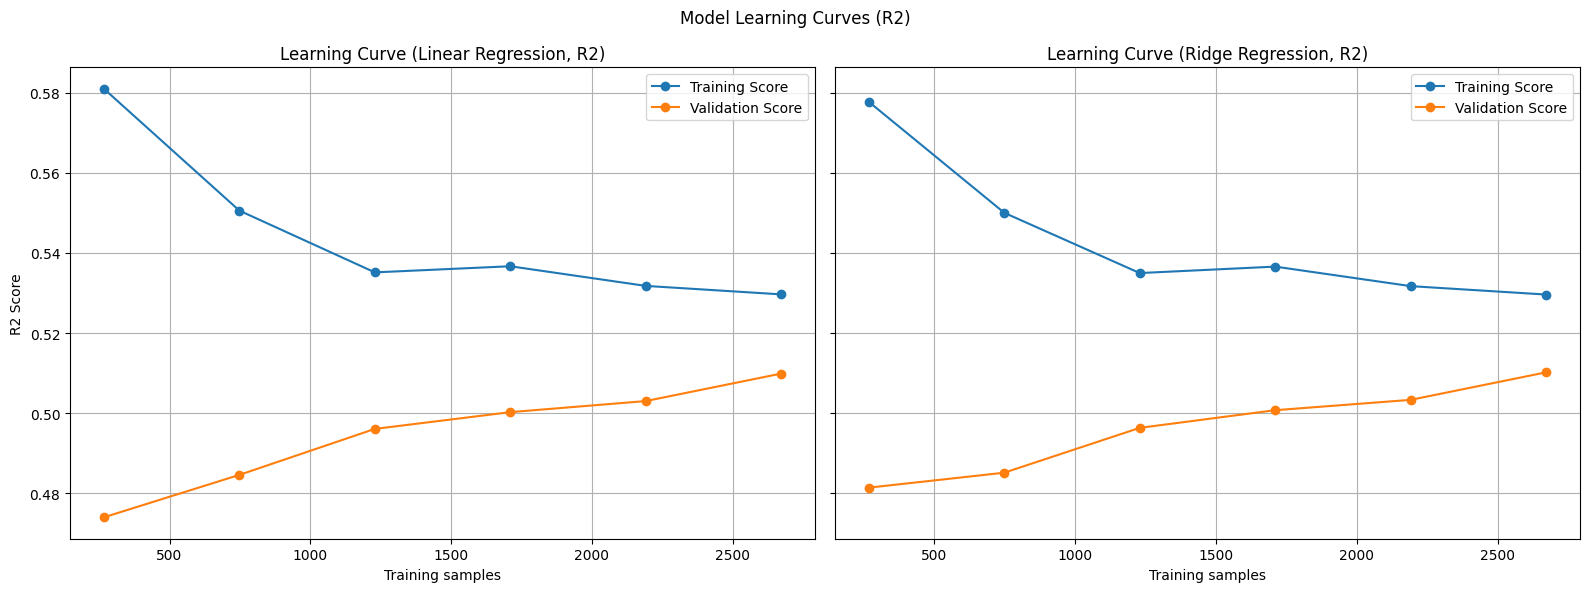

In [25]:
curve_train_sizes = np.linspace(0.1, 1.0, 6)
scoring_metric = "r2"

# Linear model
train_sizes, train_scores_lin, val_scores_lin = learning_curve(
    lin_pipe, X_train_r, y_train_r, cv=kf, scoring=scoring_metric, n_jobs=-1,
    train_sizes=curve_train_sizes, shuffle=True, random_state=RNG
)

# Ridge model
_, train_scores_ridge, val_scores_ridge = learning_curve(
    ridge_pipe, X_train_r, y_train_r, cv=kf, scoring=scoring_metric, n_jobs=-1,
    train_sizes=curve_train_sizes, shuffle=True, random_state=RNG
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

train_mean_lin = train_scores_lin.mean(axis=1)
train_std_lin = train_scores_lin.std(axis=1)
val_mean_lin = val_scores_lin.mean(axis=1)
val_std_lin = val_scores_lin.std(axis=1)

ax1.set_title("Learning Curve (Linear Regression, R2)")
ax1.plot(train_sizes, train_mean_lin, marker="o", label="Training Score", color= 'tab:blue')
ax1.plot(train_sizes, val_mean_lin, marker="o", label="Validation Score", color= 'tab:orange')
ax1.set_xlabel("Training samples")
ax1.set_ylabel("R2 Score")
ax1.legend()
ax1.grid(True)

train_mean_ridge = train_scores_ridge.mean(axis=1)
train_std_ridge = train_scores_ridge.std(axis=1)
val_mean_ridge = val_scores_ridge.mean(axis=1)
val_std_ridge = val_scores_ridge.std(axis=1)

ax2.set_title("Learning Curve (Ridge Regression, R2)")
ax2.plot(train_sizes, train_mean_ridge, marker="o", label="Training Score", color='tab:blue')
ax2.plot(train_sizes, val_mean_ridge, marker="o", label="Validation Score", color= 'tab:orange')
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("Training samples")

plt.suptitle("Model Learning Curves (R2)")
plt.tight_layout()
plt.show()


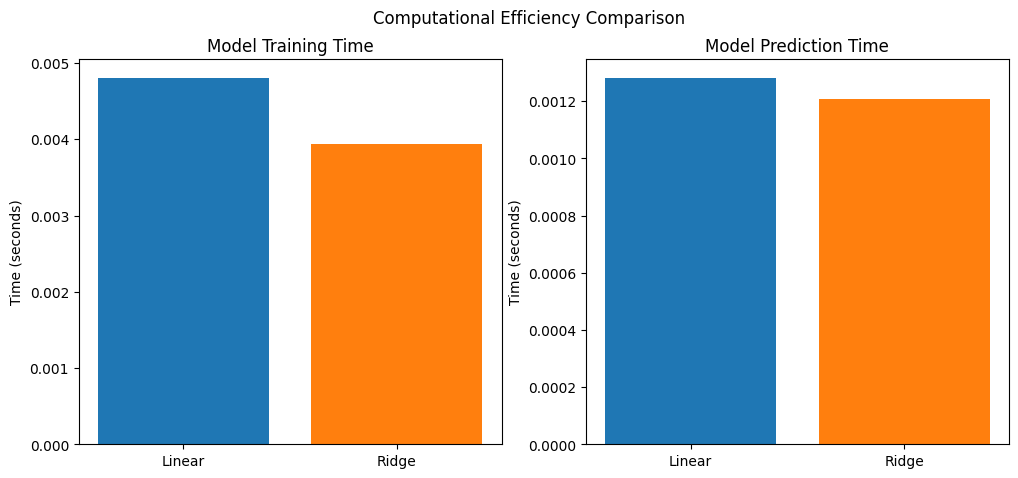

In [26]:
models = ['Linear', 'Ridge']
train_times = [lin_train_time, ridge_train_time]
pred_times = [lin_pred_time, ridge_pred_time]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training Times
ax1.bar(models, train_times, color=['tab:blue', 'tab:orange'])
ax1.set_title("Model Training Time")
ax1.set_ylabel("Time (seconds)")

# Prediction Times
ax2.bar(models, pred_times, color=['tab:blue', 'tab:orange'])
ax2.set_title("Model Prediction Time")
ax2.set_ylabel("Time (seconds)")
plt.suptitle("Computational Efficiency Comparison")
plt.show()

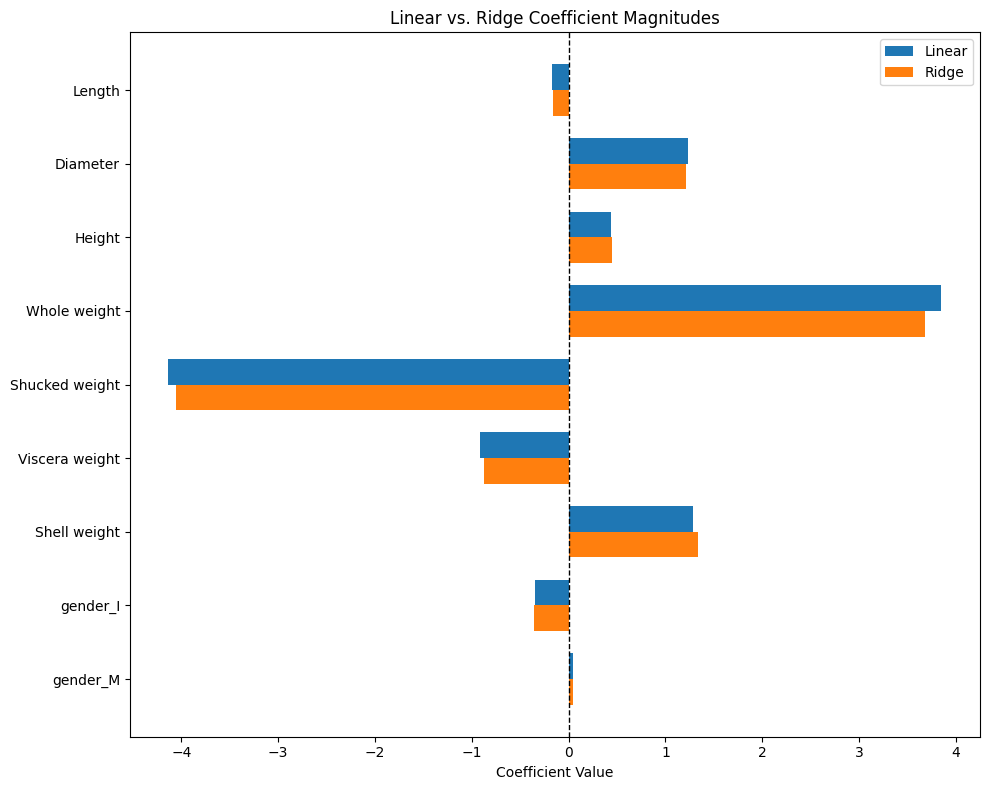

In [27]:

lin_model = lin_pipe.named_steps['model']
ridge_model = ridge_pipe.named_steps['model']

feature_names = X_train_r.columns
lin_coefs = lin_model.coef_
ridge_coefs = ridge_model.coef_

y = np.arange(len(feature_names))  
# height of bars
height = 0.35  

fig, ax = plt.subplots(figsize=(10, 8)) # Adjusted figsize for vertical plot

# Linear model
rects1 = ax.barh(y - height/2, lin_coefs, height, label='Linear', color='tab:blue')
# Ridge model
rects2 = ax.barh(y + height/2, ridge_coefs, height, label='Ridge', color='tab:orange')


ax.set_xlabel('Coefficient Value') 
ax.set_title('Linear vs. Ridge Coefficient Magnitudes')

ax.set_yticks(y) 
ax.set_yticklabels(feature_names)
ax.legend()

ax.axvline(0, color='k', linestyle='--', lw=1) # Swapped from axhline

ax.invert_yaxis() 

plt.tight_layout()
plt.show()

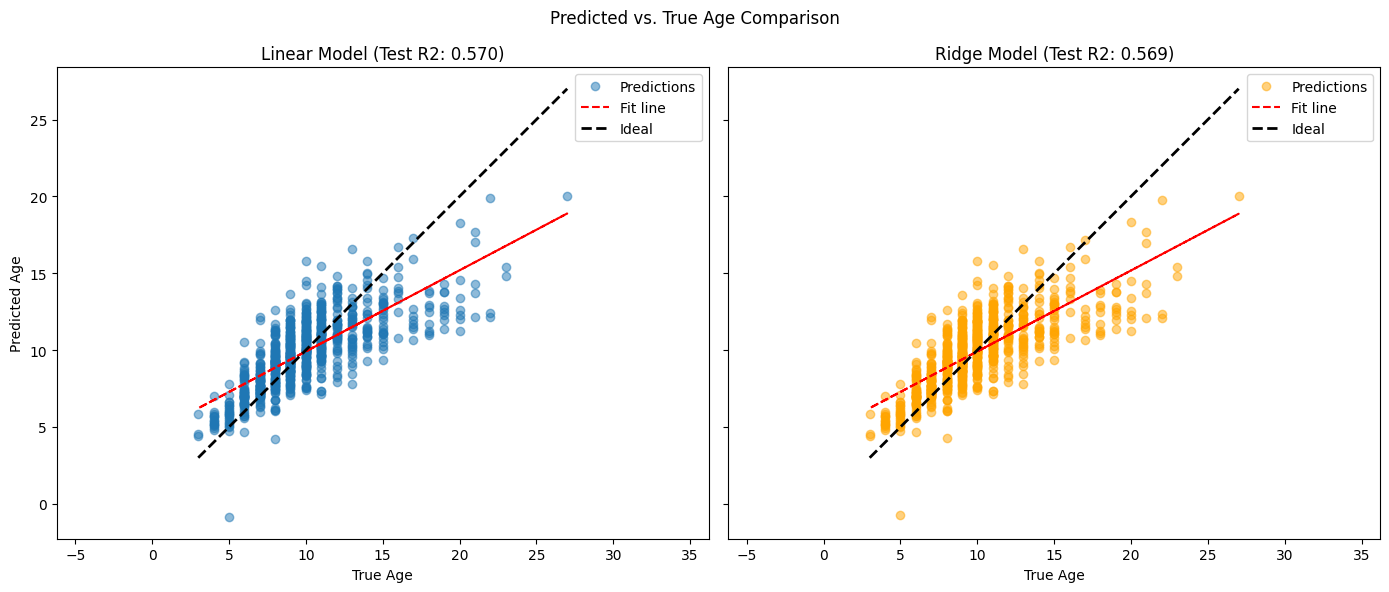

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

min_val = y_test_r.min()
max_val = y_test_r.max()


ax1.plot(y_test_r.values, y_pred_lin, 'o', alpha=0.5, label="Predictions", color='tab:blue')
ax1.set_xlabel("True Age")
ax1.set_ylabel("Predicted Age")
ax1.set_title(f"Linear Model (Test R2: {r2_lin:.3f})")

# Linear best fit line
z_lin = np.polyfit(y_test_r, y_pred_lin, 1)
p_lin = np.poly1d(z_lin)
ax1.plot(y_test_r, p_lin(y_test_r), "r--", label="Fit line")

ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label="Ideal")

# Match axes scales
ax1.axis('equal')
ax1.legend()


ax2.plot(y_test_r.values, y_pred_ridge, 'o', alpha=0.5, label="Predictions", color='orange')
ax2.set_xlabel("True Age")
ax2.set_title(f"Ridge Model (Test R2: {r2_ridge:.3f})")

# Ridge best fit line
z_ridge = np.polyfit(y_test_r, y_pred_ridge, 1)
p_ridge = np.poly1d(z_ridge)
ax2.plot(y_test_r, p_ridge(y_test_r), "r--", label="Fit line")

ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label="Ideal")

# Match axes scales
ax2.axis('equal')
ax2.legend()

plt.suptitle("Predicted vs. True Age Comparison")
plt.tight_layout() 
plt.show()